# 基于潜在语义索引算法-LSI的电影检索
#### LSI原理：根据提供词与目标电影的语义相似度来搜索

In [233]:
import os  # 解决jupyter显示图片崩溃
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 导入依赖包

In [234]:
import numpy as np 
import pandas as pd # pd数据处理，以list类型处理
import spacy
import string
import gensim
import operator
import re

## 导入数据
### 注：一般报错都是路径放错，我input文件和main.pynb同目录下。

In [235]:
df_movies = pd.read_csv('./input/movies.csv',skiprows=1, sep=',', names=['rank','title',"wiki_plot", "imdb_plot"],lineterminator="\n")
df_movies.head()

,rank,title,wiki_plot,imdb_plot
0,1,地球上的星星,天使保护事件始末。,对于8岁的男孩伊夏（达席尔·萨法瑞DarsheelSafary饰）来说，世界是充满了惊奇和快...
1,2,我爱你,你要相信，这世上真的有爱存在，不管在什么年纪,飘雪的坡道上，送牛奶的老头子金万皙（李顺载饰）邂逅了收废品的老太太宋怡芬（尹秀晶饰）。他们的...
2,3,穿越时空的少女,爱上未来的你。,17岁少女绀野真琴是一个活泼跳脱的少女。在一次普通值日工作中，真琴不小心摔倒了，自此她发现自...
3,4,香水,一个单凭体香达到高潮的男人。,十八世纪，让-马普蒂斯特•格雷诺耶（本•韦肖BenWhishaw饰）出生在巴黎最肮脏、最恶臭...
4,5,弱点,拍掉身上的悲伤，从今天开始重新踏上追梦之旅。,黑人男孩奥赫（昆东•亚伦QuintonAaron饰）自幼父母离异，无家可归。不过，木讷的他却...


## 数据清理和预处理
### 借re正则匹配删除

In [236]:
from spacy.lang.zh.stop_words import STOP_WORDS
import jieba

spacy_nlp = spacy.load('zh_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.zh.stop_words.STOP_WORDS  ## 除去暂停词，如'出去', '咚', '大体',


# 定义数据清洗函数spacy_tokenizer

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #replace extra spaces with single space
    sentence = re.sub('_','',sentence)
    
    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n','',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]','',sentence)
    
    sentence = re.sub('[a-zA-Z]','',sentence)
    
    catch = jieba.cut(sentence)
    tokens = ' '.join(catch)
    tokens = tokens.split()
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) >= 2]
    #return tokens
    return tokens

## 调用spacy_tokenizer，开始清洗文本完成分词工作

In [237]:
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['imdb_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head() 

Cleaning and Tokenizing...
Wall time: 323 ms


,rank,title,wiki_plot,imdb_plot,wiki_plot_tokenized
0,1,地球上的星星,天使保护事件始末。,对于8岁的男孩伊夏（达席尔·萨法瑞DarsheelSafary饰）来说，世界是充满了惊奇和快...,"[男孩, 伊夏达席尔萨, 法瑞饰, 世界, 充满, 惊奇, 快乐, 万花筒, 想到, 方式,..."
1,2,我爱你,你要相信，这世上真的有爱存在，不管在什么年纪,飘雪的坡道上，送牛奶的老头子金万皙（李顺载饰）邂逅了收废品的老太太宋怡芬（尹秀晶饰）。他们的...,"[飘雪, 坡道, 牛奶, 老头子, 金万皙, 李顺, 载饰, 邂逅, 废品, 老太太, 宋怡..."
2,3,穿越时空的少女,爱上未来的你。,17岁少女绀野真琴是一个活泼跳脱的少女。在一次普通值日工作中，真琴不小心摔倒了，自此她发现自...,"[17, 少女, 野真琴, 活泼, 跳脱, 少女, 值日, 工作, 中真琴, 小心, 摔倒,..."
3,4,香水,一个单凭体香达到高潮的男人。,十八世纪，让-马普蒂斯特•格雷诺耶（本•韦肖BenWhishaw饰）出生在巴黎最肮脏、最恶臭...,"[十八世纪, 马普, 蒂斯, 特格, 雷诺, 耶本, 韦肖饰, 出生, 巴黎, 肮脏, 恶臭..."
4,5,弱点,拍掉身上的悲伤，从今天开始重新踏上追梦之旅。,黑人男孩奥赫（昆东•亚伦QuintonAaron饰）自幼父母离异，无家可归。不过，木讷的他却...,"[黑人, 男孩, 奥赫昆, 东亚, 伦饰, 自幼, 父母, 离异, 无家可归, 木讷, 极强..."


In [238]:
movie_plot = df_movies['wiki_plot_tokenized']
print(movie_plot)

0      [男孩, 伊夏达席尔萨, 法瑞饰, 世界, 充满, 惊奇, 快乐, 万花筒, 想到, 方式,...
1      [飘雪, 坡道, 牛奶, 老头子, 金万皙, 李顺, 载饰, 邂逅, 废品, 老太太, 宋怡...
2      [17, 少女, 野真琴, 活泼, 跳脱, 少女, 值日, 工作, 中真琴, 小心, 摔倒,...
3      [十八世纪, 马普, 蒂斯, 特格, 雷诺, 耶本, 韦肖饰, 出生, 巴黎, 肮脏, 恶臭...
4      [黑人, 男孩, 奥赫昆, 东亚, 伦饰, 自幼, 父母, 离异, 无家可归, 木讷, 极强...
                             ...                        
245    [意大利, 南部, 小镇, 古灵精怪, 小男孩, 托托, 瓦特, 卡西欧, 喜欢, 电影, ...
246    [初三, 岛雯, 喜欢, 看书, 女孩, 每次, 借书, 卡上, 天泽圣司, 名字, 充满,...
247    [本来, 美国移民, 尤瑞, 尼古拉斯, 凯奇, 家族, 生意, 饭馆, 偶然, 机会, 踏...
248    [日本, 战国时代, 小山村, 面临, 山贼, 威胁, 保护, 秋天, 收成, 村中, 长老...
249    [艾米莉, 奥黛丽, 塔图饰, 不幸, 童年, 父亲, 健康检查, 发现, 心跳, 过快, ...
Name: wiki_plot_tokenized, Length: 250, dtype: object


## 对所有电影的词汇成词云图

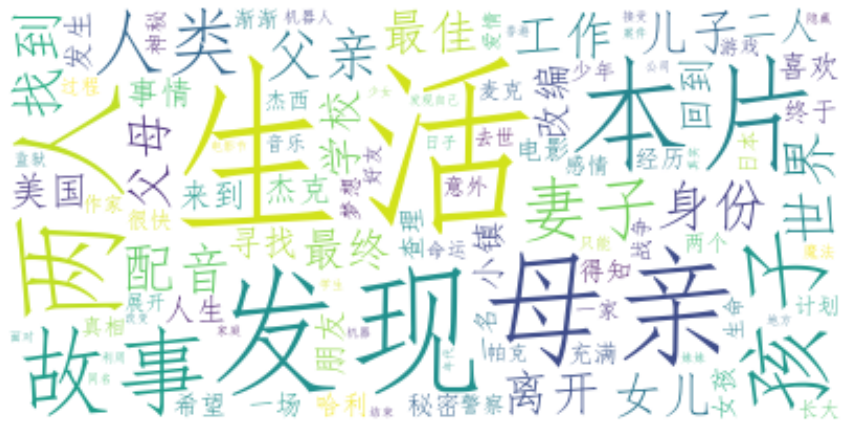

In [239]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(
    background_color='white',
    font_path = '.\script\simfang.ttf'   
).generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 基于所有词利用gensim构建词汇表，每个单词都有唯一id
### gensim：用于从原始的非结构化的文本中，无监督地学习到文本隐层的主题向量表达。

In [240]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

Wall time: 27 ms


## 打印字典中排名前50的条目和它们唯一的id

In [241]:
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['一位', 0], ['万物', 1], ['万花筒', 2], ['不好', 3], ['世界', 4], ['个性', 5], ['交流', 6], ['享受', 7], ['以往', 8], ['伊夏', 9], ['伊夏达席尔萨', 10], ['保留', 11], ['儿童', 12], ['充满', 13], ['分离', 14], ['匪夷所思', 15], ['却是', 16], ['发展', 17], ['名叫', 18], ['固守', 19], ['在内', 20], ['大地', 21], ['学校', 22], ['学生', 23], ['寄宿', 24], ['尼克', 25], ['忍无可忍', 26], ['快乐', 27], ['思想', 28], ['惊奇', 29], ['想到', 30], ['感到', 31], ['慢慢', 32], ['慷慨', 33], ['成年人', 34], ['成熟', 35], ['成绩', 36], ['成规', 37], ['排名', 38], ['改变', 39], ['方式', 40], ['日子', 41], ['汗饰', 42], ['法瑞饰', 43], ['父母', 44], ['班上', 45], ['生活', 46], ['男孩', 47], ['相处', 48], ['眼中', 49], ['美术', 50]]]


## 利用Bag of Words（词袋）模型来提取文本特征，任务如下：
### 1.已知单词的词汇量

### 2.对已知单词存在度的测量

### 字典的doc2bow函数，遍历文本中的所有单词，如果单词已经存在于语料库中，它增加频率计数，否则它将单词插入语料库并将其频率计数设置为1

In [242]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('一位', 1), ('万物', 1), ('万花筒', 1), ('不好', 1), ('世界', 2), ('个性', 1), ('交流', 1), ('享受', 1), ('以往', 1), ('伊夏', 3), ('伊夏达席尔萨', 1), ('保留', 1), ('儿童', 1), ('充满', 2), ('分离', 1), ('匪夷所思', 1), ('却是', 1), ('发展', 1), ('名叫', 1), ('固守', 1), ('在内', 1), ('大地', 1), ('学校', 1), ('学生', 1), ('寄宿', 1), ('尼克', 4), ('忍无可忍', 1), ('快乐', 1), ('思想', 1), ('惊奇', 1), ('想到', 1), ('感到', 1), ('慢慢', 1), ('慷慨', 1), ('成年人', 1), ('成熟', 1), ('成绩', 1), ('成规', 1), ('排名', 1), ('改变', 1), ('方式', 1), ('日子', 1), ('汗饰', 1), ('法瑞饰', 1), ('父母', 2), ('班上', 1), ('生活', 3), ('男孩', 1), ('相处', 1), ('眼中', 1), ('美术', 1), ('老师', 2), ('脑子里', 1), ('自由', 1), ('见到', 1), ('赠与', 1), ('走进', 1), ('送往', 1), ('闯下大祸', 1), ('闷闷不乐', 1), ('阿米尔', 1), ('陌生', 1), ('鬼点子', 1)], [('生活', 1), ('一次次', 1), ('万皙', 3), ('两位', 1), ('人生', 1), ('作品', 1), ('做出', 1), ('停车场', 1), ('公演', 1), ('军峰', 2), ('凌晨', 1), ('初恋', 1), ('前半生', 1), ('受到好评', 1), ('同名', 2), ('坡道', 1), ('城市', 1), ('夭折', 1), ('妻子', 1), ('姜草', 1), ('孙女', 1), ('孤独', 1), ('孩子', 1), ('宋怡芬', 1), ('宋智孝饰', 1), ('

## 利用TF_IDF来选择最匹配的词；一旦TF_IDF被构建，之后传递给LSI模型，并指定要构建的特征的数量


### LSI是一个基于奇异值分解（SVD）的方法来得到句子的特征的主题模型，目的是对文字建立出隐含特征
### 其他主题模型：LDA、HDP等

In [243]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

Wall time: 31 ms
Wall time: 1.01 s


In [244]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

Wall time: 196 ms
Wall time: 307 ms


In [245]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(250 documents, 7848 features, 13014 non-zero entries)
MmCorpus(250 documents, 197 features, 38809 non-zero entries)


In [246]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

Wall time: 104 ms


## 用于搜索索引、排序并返回结果的search_similar_movies函数

In [247]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                '相关度': round((movie[1] * 100),2),
                '电影名称': df_movies['title'][movie[0]],
                '电影简介': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['相关度','电影名称','电影简介'])

## 测试环节
### 给定关键词，判断电影名称

In [292]:
search_similar_movies('音乐 古典')

,相关度,电影名称,电影简介
0,64.84,波西米亚狂想曲,NaN
1,40.46,放牛班的春天,天籁一般的童声，是最接近上帝的存在。
2,39.09,寻梦环游记,死亡不是真的逝去，遗忘才是永恒的消亡。
3,35.97,爆裂鼓手,这个世界从不善待努力的人，努力了也不一定会成功，但是知道自己在努力，就是活下去的动力。
4,25.94,心灵奇旅,NaN


In [291]:
# search for movie tiles that are related to below search parameters
search_similar_movies('讽刺 社会 悲剧')

,相关度,电影名称,电影简介
0,63.76,荒蛮故事,始于荒诞，止于更荒诞。
1,43.62,闻香识女人,史上最美的探戈。
2,33.35,素媛,受过伤害的人总是笑得最开心，因为他们不愿意让身边的人承受一样的痛苦。
3,33.04,霸王别姬,风华绝代。
4,26.97,牯岭街少年杀人事件,弱者送给弱者的一刀。
